In [9]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from easydict import EasyDict as edict

from torchvision import datasets
from torchvision import transforms as trans

from pathlib import Path
from models.yolo_body_res50 import Yolo_body
import numpy as np
import torch
from torch import nn,optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook
from imgaug import augmenters as iaa
from Yolo_trainer import Yolo

In [3]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = datasets.CocoDetection(conf.train_path, conf.train_anno_path)
coco_class_2_id, coco_id_2_class = get_coco_class_name_map(
    conf.train_anno_path)
conf.class_num = len(coco_id_2_class)

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

train_dataset.maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

train_dataset.maps = [id_2_correct_id,correct_id_2_id,correct_id_2_class,class_2_correct_id]

val_dataset = datasets.CocoDetection(conf.val_path, conf.val_anno_path)
val_dataset.maps = train_dataset.maps

loading annotations into memory...
Done (t=9.64s)
creating index...
index created!
loading annotations into memory...
Done (t=9.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [5]:
model = Yolo_body(conf.class_num)
model.to(conf.device)
conf.mean = model.res50_pyramid.model.mean
conf.std = model.res50_pyramid.model.std

seq = iaa.Sequential([
    iaa.SomeOf(
        (1, 2),
        children=[
            iaa.GaussianBlur((0., 2.)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.15 * 255)),
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
            iaa.CoarseSaltAndPepper(p=(0., 0.1), size_percent=0.03)
        ],
        random_order=True)
])

conf.batch_size = 16
conf.input_size = [416, 416]
conf.transform_train = trans.Compose([
    trans.Resize(conf.input_size),
    trans.Lambda(lambda x: Image.fromarray(seq.augment_image(np.array(x)))),
    trans.ColorJitter(0.2, 0.2, 0.2, 0.1),
    trans.ToTensor(),
    trans.Normalize(conf.mean, conf.std)
])
conf.transform_test = trans.Compose([
    trans.Resize(conf.input_size),
    trans.ToTensor(),
    trans.Normalize(conf.mean, conf.std)
])

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.5

train_loader = Coco_loader(
    conf, train_dataset, conf.transform_train, batch_size=conf.batch_size)
val_loader = Coco_loader(
    conf,
    val_dataset,
    conf.transform_test,
    batch_size=conf.batch_size,
    hflip=False,
    shuffle=False)

# conf.board_loss_every = 5
# conf.evaluate_every = 5
# conf.board_pred_image_every = 5
conf.board_loss_every = len(train_loader) // 100
conf.evaluate_every = len(train_loader) // 10
conf.board_pred_image_every = len(train_loader) // 5

In [6]:
writer = SummaryWriter(conf.log_path/'finetune_first')

In [7]:
paras = [*model.parameters()][9:]

optimizer = optim.SGD(paras,lr=3e-5,momentum=0.9,weight_decay=1e-4)

In [8]:
yolo = Yolo(conf,model,train_loader,val_loader,writer,optimizer)

 62%|██████▏   | 4577/7392 [1:38:48<1:00:46,  1.30s/it]

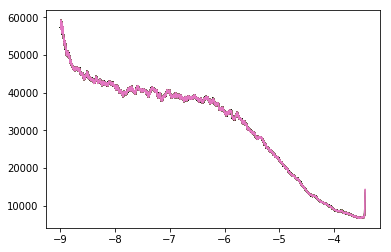

In [10]:
log_lrs, losses = yolo.find_lr(conf,1e-9,1)

In [ ]:
# yolo.train(conf,1,'finetuning')

In [ ]:
%debug